In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

In [2]:
rootpath = "../data"
sub_id = "dy016"
samp_freq = 30_000

In [3]:
# load behavior data
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

# preprocess behavior data
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict)
static_behaviors = {'choice': choices, 'stimulus': one_hot_stimuli}

choices left: 0.231, right: 0.231
stimuli left: 0.507, right: 0.493
reward wrong: 0.769, correct: 18.851


all

In [4]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=False, samp_freq=samp_freq)

# load kilosort units that passed ibl's quality metrics
good_ks_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi='all', keep_active_trials = False, samp_freq=30_000)

# load kilosort unsorted data
ks_unsorted_indices = data_preprocess.load_kilosort_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials = False, samp_freq=30_000)

In [11]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=False, samp_freq=samp_freq)

# load clusterless model
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

# # load gmm after split-merge
# gmm = split_merge.merge_gaussians('..', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, init_method=None, fit_model=False)
# labels = gmm.predict(structured_unsorted)
# probs = gmm.predict_proba(structured_unsorted)

In [5]:
# prepare time binned neural activity for decoding
n_projs = 10
neural_data_dict = dict()
tpca_recon_dict = dict()

# sorted_neural_data = data_preprocess.compute_time_binned_neural_activity((ks_spikes_times, ks_spikes_clusters), 'sorted', stimulus_onset_times, regional=False)
# sorted_tpca_proj, sorted_tpca_recon = smooth_signals.tpca(sorted_neural_data, n_projs=n_projs)
# neural_data_dict.update({'sorted': sorted_neural_data})
# tpca_recon_dict.update({'sorted': sorted_tpca_recon})

# good_ks_neural_data = data_preprocess.compute_time_binned_neural_activity(good_ks_spikes_indices, 'good units', stimulus_onset_times, regional=False)
# good_ks_tpca_proj, good_ks_tpca_recon = smooth_signals.tpca(good_ks_neural_data, n_projs=n_projs)
# neural_data_dict.update({'good units': good_ks_neural_data})
# tpca_recon_dict.update({'good units': good_ks_tpca_recon})

# ks_unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(ks_unsorted_indices, 'kilosort unsorted', stimulus_onset_times, regional=False)
# ks_unsorted_tpca_proj, ks_unsorted_tpca_recon = smooth_signals.tpca(ks_unsorted_neural_data, n_projs=n_projs)
# neural_data_dict.update({'kilosort unsorted': ks_unsorted_neural_data})
# tpca_recon_dict.update({'kilosort unsorted': ks_unsorted_tpca_recon})

# unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(spikes_indices, 'unsorted', stimulus_onset_times, regional=False)
# unsorted_tpca_proj, unsorted_tpca_recon = smooth_signals.tpca(unsorted_neural_data, n_projs=n_projs)
# neural_data_dict.update({'unsorted': unsorted_neural_data})
# tpca_recon_dict.update({'unsorted': unsorted_tpca_recon})

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, labels, probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=n_projs)
neural_data_dict.update({'clusterless': clusterless_neural_data})
tpca_recon_dict.update({'clusterless': clusterless_tpca_recon})

In [6]:
# decode using original neural activity
all_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(neural_data_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        all_decode_results[behave_type].update({data_type: decode_results})
# np.save(f'{rootpath}/{sub_id}/decode_results/non_clusterless_decode_results', all_decode_results)
np.save(f'{rootpath}/{sub_id}/decode_results/clusterless_decode_results', all_decode_results)

clusterless decoding ...
choice fold 1 test accuracy: 0.966 auc: 0.807
choice fold 2 test accuracy: 0.982 auc: 0.806
choice fold 3 test accuracy: 0.982 auc: 0.836
choice fold 4 test accuracy: 0.965 auc: 0.867
choice fold 5 test accuracy: 0.982 auc: 0.817
choice mean of 5-fold cv accuracy: 0.976 auc: 0.826
choice sd of 5-fold cv accuracy: 0.008 auc: 0.023
clusterless decoding ...
stimulus fold 1 test accuracy: 0.293 auc: 0.797
stimulus fold 2 test accuracy: 0.351 auc: 0.772
stimulus fold 3 test accuracy: 0.281 auc: 0.723
stimulus fold 4 test accuracy: 0.333 auc: 0.831
stimulus fold 5 test accuracy: 0.351 auc: 0.780
stimulus mean of 5-fold cv accuracy: 0.322 auc: 0.781
stimulus sd of 5-fold cv accuracy: 0.029 auc: 0.035


In [7]:
# decode using smoothed neural activity by tpca
all_tpca_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_tpca_decode_results.keys():
    for data_type in tpca_recon_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(tpca_recon_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        all_tpca_decode_results[behave_type].update({data_type: decode_results})
# np.save(f'{rootpath}/{sub_id}/decode_results/non_clusterless_tpca_decode_results', all_tpca_decode_results)
np.save(f'{rootpath}/{sub_id}/decode_results/clusterless_tpca_decode_results', all_tpca_decode_results)

clusterless decoding ...
choice fold 1 test accuracy: 0.966 auc: 0.818
choice fold 2 test accuracy: 0.982 auc: 0.823
choice fold 3 test accuracy: 0.982 auc: 0.835
choice fold 4 test accuracy: 0.965 auc: 0.858
choice fold 5 test accuracy: 1.000 auc: 0.832
choice mean of 5-fold cv accuracy: 0.979 auc: 0.833
choice sd of 5-fold cv accuracy: 0.013 auc: 0.014
clusterless decoding ...
stimulus fold 1 test accuracy: 0.345 auc: 0.789
stimulus fold 2 test accuracy: 0.281 auc: 0.745
stimulus fold 3 test accuracy: 0.316 auc: 0.747
stimulus fold 4 test accuracy: 0.386 auc: 0.858
stimulus fold 5 test accuracy: 0.333 auc: 0.784
stimulus mean of 5-fold cv accuracy: 0.332 auc: 0.785
stimulus sd of 5-fold cv accuracy: 0.035 auc: 0.041


regional

In [27]:
rois = ['PO', 'LP', 'DG', 'CA1', 'PPC']
roi = rois[4]

In [28]:
# load sorted data
regional_sorted = data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, roi=roi, keep_active_trials = False, samp_freq=30_000)

# load kilosort units that passed ibl's quality metrics
regional_good_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi=roi, keep_active_trials = False, samp_freq=30_000)

# load kilosort unsorted data
regional_ks_unsorted = data_preprocess.load_kilosort_unsorted_data(rootpath, sub_id, roi=roi, keep_active_trials = False, samp_freq=30_000)

In [29]:
# load unsorted datas
regional_trials = data_preprocess.load_unsorted_data(rootpath, sub_id, roi=roi, keep_active_trials=False, samp_freq=30_000)
regional_spikes_times = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,0]
regional_unsorted = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,:2]

# load clusterless data
regional_clusterless = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,2:]

# load gmm after split-merge
gmm = split_merge.merge_gaussians('..', sub_id, None, post_split_gmm=None, post_split_labels=None, merge_ids=None, init_method=None, fit_model=False)
regional_labels = gmm.predict(regional_clusterless)
regional_probs = gmm.predict_proba(regional_clusterless)

found 15 channels in roi PPC


In [30]:
# prepare time binned neural activity for decoding
n_projs = 10
neural_data_dict = dict()
tpca_recon_dict = dict()

regional_sorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_sorted, 'sorted', stimulus_onset_times, regional=True)
regional_sorted_tpca_proj, regional_sorted_tpca_recon = smooth_signals.tpca(regional_sorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'sorted': regional_sorted_neural_data})
tpca_recon_dict.update({'sorted': regional_sorted_tpca_recon})

regional_good_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_good_spikes_indices, 'good units', stimulus_onset_times, regional=True)
regional_good_tpca_proj, regional_good_tpca_recon = smooth_signals.tpca(regional_good_neural_data, n_projs=n_projs)
neural_data_dict.update({'good units': regional_good_neural_data})
tpca_recon_dict.update({'good units': regional_good_tpca_recon})

regional_ks_unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_ks_unsorted, 'kilosort unsorted', stimulus_onset_times, regional=True)
regional_ks_unsorted_tpca_proj, ks_unsorted_tpca_recon = smooth_signals.tpca(regional_ks_unsorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'kilosort unsorted': regional_ks_unsorted_neural_data})
tpca_recon_dict.update({'kilosort unsorted': regional_ks_unsorted_tpca_proj})

regional_unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_unsorted, 'unsorted', stimulus_onset_times, regional=True)
regional_unsorted_tpca_proj, regional_unsorted_tpca_recon = smooth_signals.tpca(regional_unsorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'unsorted': regional_unsorted_neural_data})
tpca_recon_dict.update({'unsorted': regional_unsorted_tpca_recon})

regional_clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((regional_spikes_times, regional_labels, regional_probs), 
                                            'clusterless', stimulus_onset_times, regional=True)
regional_clusterless_tpca_proj, regional_clusterless_tpca_recon = smooth_signals.tpca(regional_clusterless_neural_data, n_projs=n_projs)
neural_data_dict.update({'clusterless': regional_clusterless_neural_data})
tpca_recon_dict.update({'clusterless': regional_clusterless_tpca_recon})

In [31]:
# decode using original neural activity
regional_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(neural_data_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        regional_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_decode_results', regional_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.810 auc: 0.731
choice fold 2 test accuracy: 0.912 auc: 0.770
choice fold 3 test accuracy: 0.807 auc: 0.655
choice fold 4 test accuracy: 0.860 auc: 0.763
choice fold 5 test accuracy: 0.912 auc: 0.755
choice mean of 5-fold cv accuracy: 0.860 auc: 0.735
choice sd of 5-fold cv accuracy: 0.046 auc: 0.042
good units decoding ...
choice fold 1 test accuracy: 0.810 auc: 0.609
choice fold 2 test accuracy: 0.912 auc: 0.784
choice fold 3 test accuracy: 0.825 auc: 0.665
choice fold 4 test accuracy: 0.842 auc: 0.759
choice fold 5 test accuracy: 0.895 auc: 0.729
choice mean of 5-fold cv accuracy: 0.857 auc: 0.709
choice sd of 5-fold cv accuracy: 0.040 auc: 0.064
kilosort unsorted decoding ...
choice fold 1 test accuracy: 0.759 auc: 0.647
choice fold 2 test accuracy: 0.772 auc: 0.674
choice fold 3 test accuracy: 0.825 auc: 0.605
choice fold 4 test accuracy: 0.772 auc: 0.719
choice fold 5 test accuracy: 0.807 auc: 0.682
choice mean of 5-fold cv accura

In [32]:
# decode using smoothed neural activity by tpca
regional_tpca_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_tpca_decode_results.keys():
    for data_type in tpca_recon_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(tpca_recon_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        regional_tpca_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_tpca_decode_results', regional_tpca_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.897 auc: 0.795
choice fold 2 test accuracy: 0.965 auc: 0.774
choice fold 3 test accuracy: 0.912 auc: 0.707
choice fold 4 test accuracy: 0.877 auc: 0.776
choice fold 5 test accuracy: 0.930 auc: 0.712
choice mean of 5-fold cv accuracy: 0.916 auc: 0.753
choice sd of 5-fold cv accuracy: 0.030 auc: 0.036
good units decoding ...
choice fold 1 test accuracy: 0.828 auc: 0.647
choice fold 2 test accuracy: 0.912 auc: 0.792
choice fold 3 test accuracy: 0.807 auc: 0.746
choice fold 4 test accuracy: 0.842 auc: 0.727
choice fold 5 test accuracy: 0.860 auc: 0.726
choice mean of 5-fold cv accuracy: 0.850 auc: 0.728
choice sd of 5-fold cv accuracy: 0.036 auc: 0.047
kilosort unsorted decoding ...
choice fold 1 test accuracy: 0.793 auc: 0.686
choice fold 2 test accuracy: 0.877 auc: 0.703
choice fold 3 test accuracy: 0.789 auc: 0.654
choice fold 4 test accuracy: 0.825 auc: 0.708
choice fold 5 test accuracy: 0.860 auc: 0.684
choice mean of 5-fold cv accura

plotting

In [ ]:
rois = ['po', 'lp', 'dg', 'ca1', 'ppc']

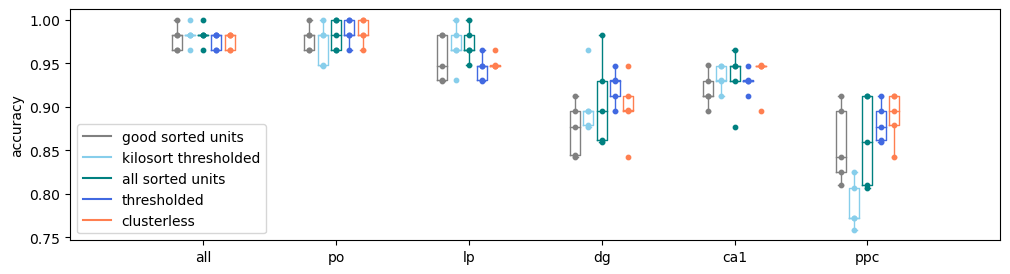

In [7]:
# box plots for choice
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='accuracy', rois = rois, n_folds=5, add_smooth=False, fig_size=(12,3), font_size=10, save_fig=True)

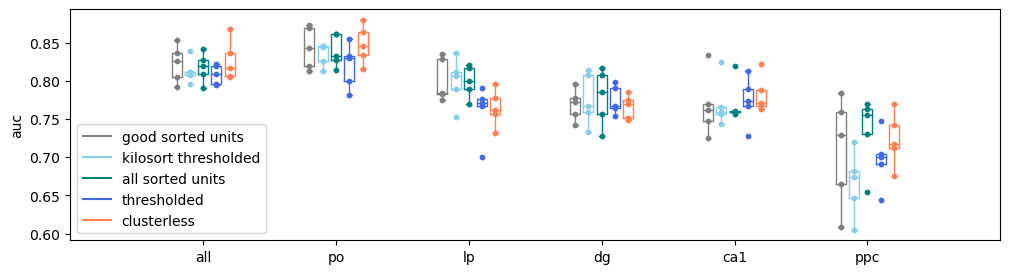

In [6]:
# box plots for choice
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='auc', rois = rois, n_folds=5, add_smooth=False, fig_size=(12,3), font_size=10, save_fig=True)

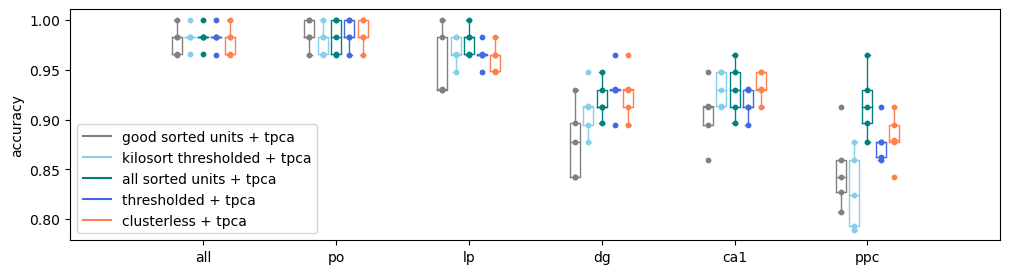

In [8]:
# box plots for choice + tpca
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='accuracy', rois = rois, n_folds=5, add_smooth=True, fig_size=(12,3), font_size=10, save_fig=True)

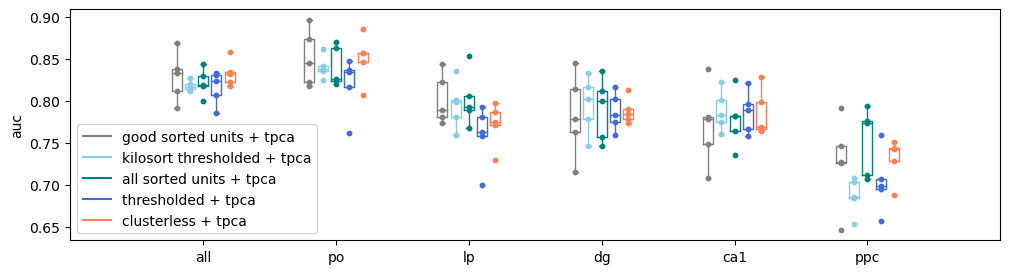

In [9]:
# box plots for choice + tpca
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='auc', rois = rois, n_folds=5, add_smooth=True, fig_size=(12,3), font_size=10, save_fig=True)

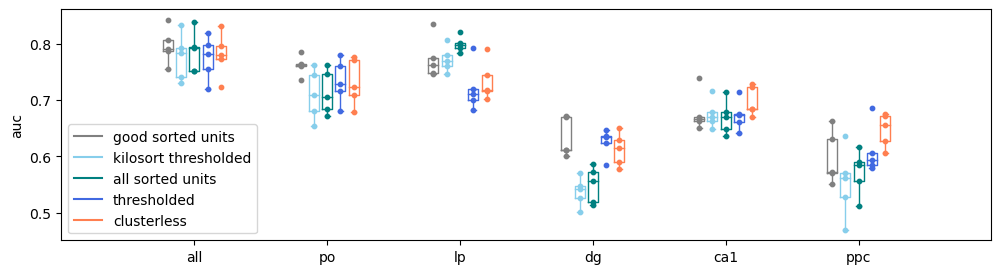

In [10]:
# box plots for stimulus
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='auc', rois = rois, n_folds=5, add_smooth=False, fig_size=(12,3), font_size=10, save_fig=True)

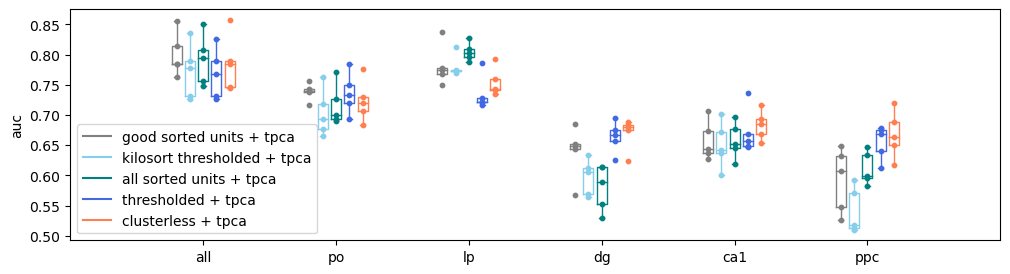

In [11]:
# box plots for choice + tpca
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='auc', rois = rois, n_folds=5, add_smooth=True, fig_size=(12,3), font_size=10, save_fig=True)

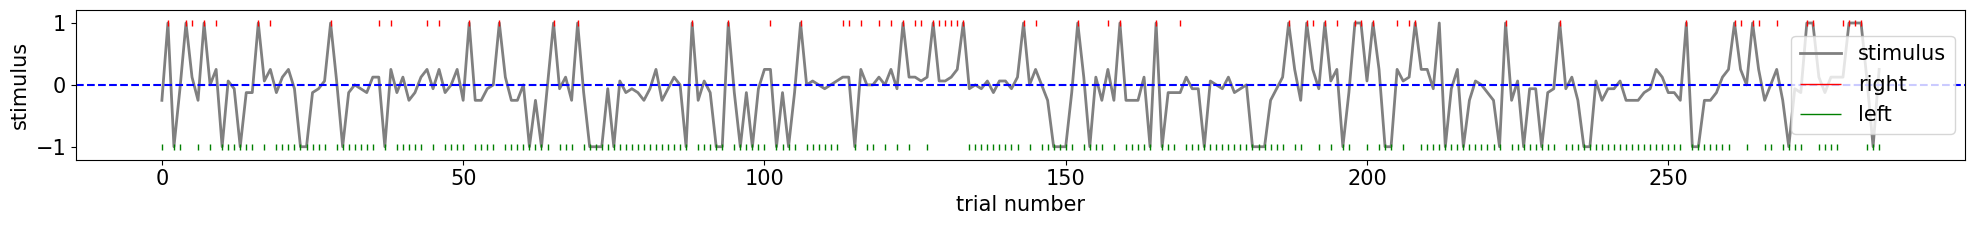

In [12]:
# visualize stimuli traces
viz_tools.plot_static_behavior_traces(rootpath, sub_id, choices, transformed_stimuli, fig_size=(20, 2.5), font_size=15, save_fig=True)

In [5]:
trial_ids = np.hstack(all_tpca_decode_results['stimulus']['clusterless'][2])
transformed_pred_stimuli= np.hstack(all_tpca_decode_results['stimulus']['clusterless'][-2])
transformed_obs_stimuli = np.vstack(all_tpca_decode_results['stimulus']['clusterless'][3]).argmax(1)

In [6]:
pred_stimuli = data_preprocess.inverse_transform_stimulus(transformed_pred_stimuli, enc_categories)
obs_stimuli = data_preprocess.inverse_transform_stimulus(transformed_obs_stimuli, enc_categories)

{0: -1.0, 1: -0.25, 2: -0.125, 3: -0.0625, 4: 0.0, 5: 0.0625, 6: 0.125, 7: 0.25, 8: 1.0}
{0: -1.0, 1: -0.25, 2: -0.125, 3: -0.0625, 4: 0.0, 5: 0.0625, 6: 0.125, 7: 0.25, 8: 1.0}


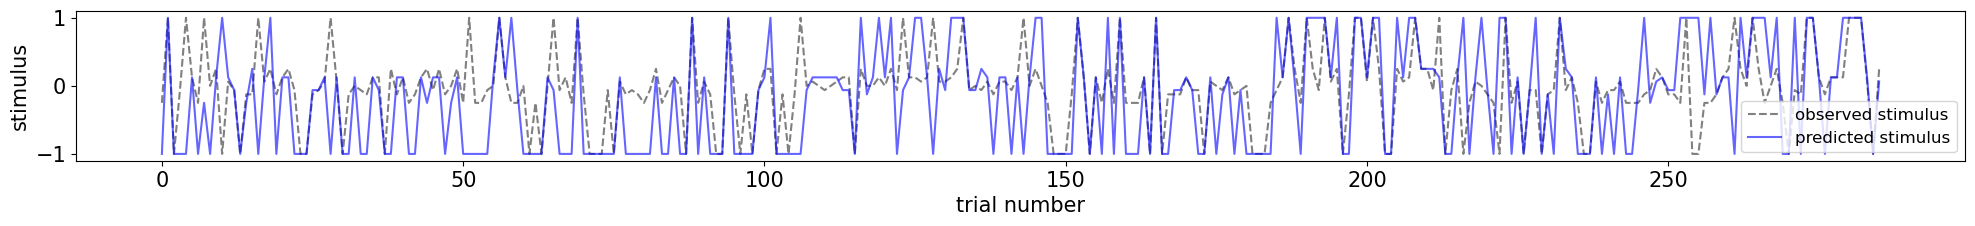

In [13]:
viz_tools.plot_compare_obs_pred_static_behavior_traces(rootpath, sub_id, behave_type='stimulus', data_type='clusterless_tpca', trial_ids=trial_ids, obs_behaviors=obs_stimuli, pred_behaviors=pred_stimuli, fig_size=(20, 2.5), font_size=15, save_fig=True)

In [ ]:
# heatmap comparison


